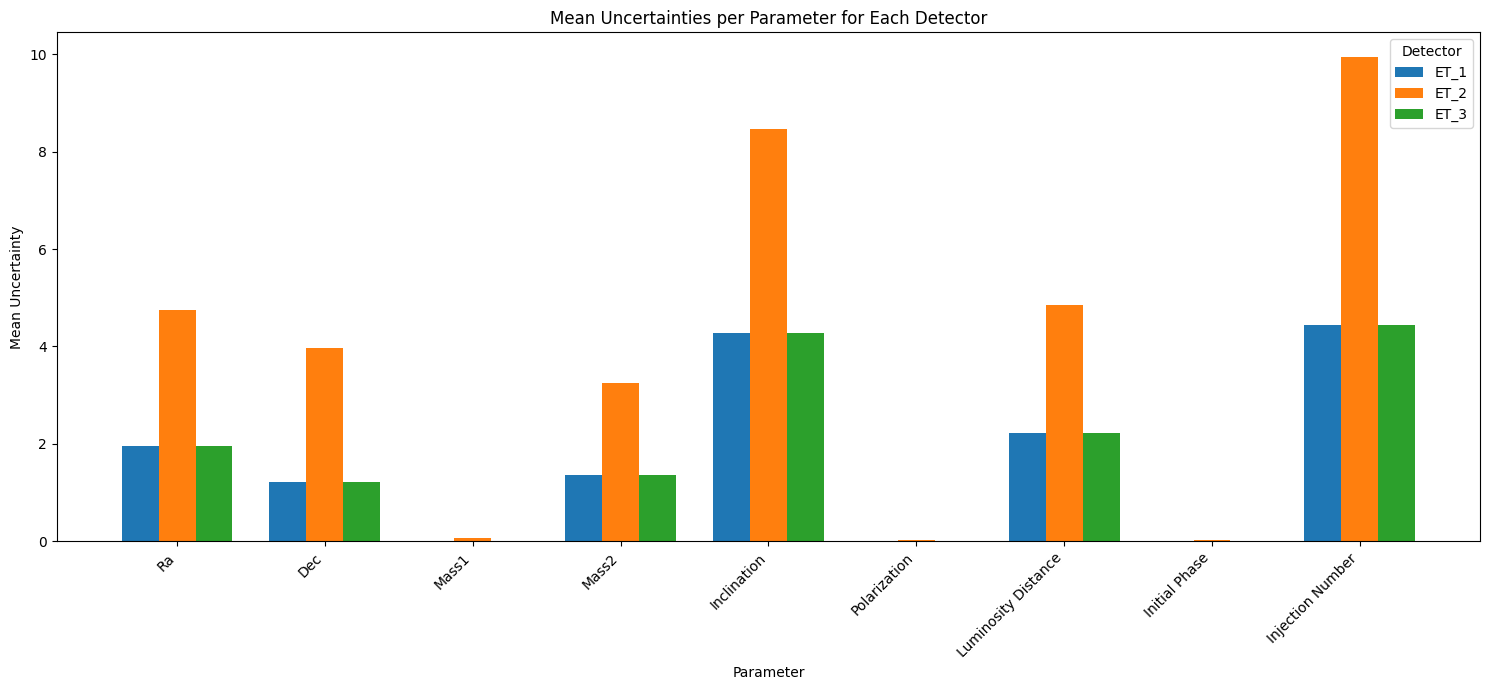


Uncertainty Summary Statistics for ET_1:
                        mean      std      min       max
Ra                  1.963884 1.880026 0.012532 10.250420
Dec                 1.209241 1.087241 0.011933  4.138383
Mass1               0.004811 0.003646 0.000090  0.015182
Mass2               1.352091 1.252464 0.016032  5.442401
Inclination         4.277500 1.626476 0.349203  9.893734
Polarization        0.000739 0.000368 0.000238  0.002319
Luminosity Distance 2.232787 2.430414 0.009445  9.102951
Initial Phase       0.000716 0.000357 0.000231  0.002248
Injection Number    4.431439 3.454578 0.174323  9.021032

Uncertainty Summary Statistics for ET_2:
                        mean      std      min       max
Ra                  4.758963 3.283362 0.029169 10.407445
Dec                 3.974706 2.810539 0.012719 10.108420
Mass1               0.067867 0.037138 0.015634  0.176790
Mass2               3.247169 1.829022 0.132367  8.514650
Inclination         8.473118 1.699334 1.598419  9.986331
Pola

In [9]:
import os
import numpy as np
import pickle
import csv
import pandas as pd
import matplotlib.pyplot as plt

# List of parameter names
PARAM_NAMES = [
    "Ra", "Dec", "Mass1", "Mass2", 
    "Inclination", "Polarization", 
    "Luminosity Distance", "Initial Phase", "Injection Number"
]

# List of detector names
DETECTORS = ["ET_1", "ET_2", "ET_3"]

# Dynamic regularization function
def get_dynamic_epsilon(matrix):
    cond_number = np.linalg.cond(matrix)
    eigvals = np.linalg.eigvals(matrix)
    eigval_std = np.std(eigvals)

    if cond_number > 1e20 or eigval_std > 1e2:
        return 1e-2
    elif cond_number > 1e16 or eigval_std > 1e1:
        return 1e-3
    elif cond_number > 1e12:
        return 1e-4
    else:
        return 1e-6

# Ensure the matrix is positive definite
def ensure_positive_definite(matrix):
    eigvals, eigvecs = np.linalg.eigh(matrix)
    eigvals_clipped = np.clip(eigvals, 1e-8, None)
    return eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T

# Regularize the matrix
def regularize_matrix(matrix):
    epsilon = get_dynamic_epsilon(matrix)
    matrix_sym = (matrix + matrix.T) / 2
    return ensure_positive_definite(matrix_sym + epsilon * np.eye(matrix.shape[0]))

# Compute the covariance matrix
def compute_covariance(fisher_matrix):
    reg_matrix = regularize_matrix(fisher_matrix)
    return np.linalg.pinv(reg_matrix)

# Compute uncertainties from the covariance matrix
def compute_uncertainties(cov_matrix):
    return np.sqrt(np.diag(cov_matrix))

# Process all folders and extract uncertainties
def process_all_folders(base_dir):
    results = []

    for i in range(200):
        folder_path = os.path.join(base_dir, f'output_{i}', 'R_ET_1_ET_2_ET_3')
        pkl_file_path = os.path.join(folder_path, 'R_ET_1_ET_2_ET_3_0.pkl')

        if not os.path.exists(pkl_file_path):
            continue

        with open(pkl_file_path, 'rb') as file:
            data = pickle.load(file)

        fisher_matrices = [data[1], data[2][0], data[2][1]]

        folder_result = {'folder': f'output_{i}'}
        for j, fisher_matrix in enumerate(fisher_matrices, start=1):
            if fisher_matrix.shape != (9, 9):
                continue

            cov_matrix = compute_covariance(fisher_matrix)
            uncertainties = compute_uncertainties(cov_matrix)

            for k, param_name in enumerate(PARAM_NAMES):
                folder_result[f'{DETECTORS[j-1]}_{param_name}'] = uncertainties[k]

        results.append(folder_result)

    return results

# Save results to a CSV file
def save_results_to_csv(results, output_file):
    df = pd.DataFrame(results)
    df.to_csv(output_file, index=False)

# Visualize uncertainties with a combined bar chart
def visualize_uncertainties(csv_file):
    data = pd.read_csv(csv_file)

    # Configure bar width and position offsets
    bar_width = 0.25
    x = np.arange(len(PARAM_NAMES))

    plt.figure(figsize=(15, 7))

    # Plot each detector's uncertainties with different colors and offsets
    for i, detector in enumerate(DETECTORS):
        mean_uncertainties = data[
            [f'{detector}_{param}' for param in PARAM_NAMES]
        ].mean().values

        plt.bar(x + i * bar_width, mean_uncertainties, width=bar_width, label=detector)

    # Set x-axis labels and ticks
    plt.xticks(x + bar_width, PARAM_NAMES, rotation=45, ha='right')
    plt.xlabel('Parameter')
    plt.ylabel('Mean Uncertainty')
    plt.title('Mean Uncertainties per Parameter for Each Detector')
    plt.legend(title='Detector')

    plt.tight_layout()
    plt.show()

    # Display summary statistics for each detector
    for detector in DETECTORS:
        detector_data = data[[f'{detector}_{param}' for param in PARAM_NAMES]]
        summary_stats = detector_data.describe().transpose()[["mean", "std", "min", "max"]]
        summary_stats.index = PARAM_NAMES  # Set index to parameter names
        print(f"\nUncertainty Summary Statistics for {detector}:")
        print(summary_stats.to_string(float_format="%.6f"))

# Main program
if __name__ == "__main__":
    base_dir = "/Users/ciel/ET/KL_test_200Mpc"
    output_file = "fisher_uncertainties_regularized.csv"

    # Process all folders and save results
    results = process_all_folders(base_dir)
    save_results_to_csv(results, output_file)

    # Visualize uncertainties and print summary statistics
    visualize_uncertainties(output_file)

    print(f"\nUncertainty results saved to {output_file}")
